In [1]:
from hopper import Hopper1
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import mujoco as mj
import multiprocessing

In [2]:
xml_path = "./xml/hopper1/scene.xml"
# 储存所有数据的列表，不同批次的实验使用不同的二维列表
class AllData:
    def __init__(self) -> None:
        self.all_time_datas = []
        self.all_kinetic_energy_datas = []
        self.all_potential_energy_datas = []
        self.all_total_energy_datas = []
        self.all_cm_height_datas = []
        self.all_cm_velocity_datas = []
        self.all_cm_acceleration_datas = []
        self.all_tenser_stiffness_datas = []
        self.all_tenser_length_datas = []

## 改变弹簧刚度实验
改变弹簧刚度，从50加到400，测试

改进：使用了多进程加快实验速度

### 离开地面前质心高度和速度、加速度、能量的关系

起跳过程离开地面前，随着质心高度增大，质心的速度增大。

不同的实验改变了弹簧的刚度，发现离开地面时质心所处的高度随着弹簧刚度增大而减小，换句话说，增加弹簧的刚度，会使机构提前起跳。

随着弹簧刚度的增大，离开地面瞬间的质心高度增加,离开地面瞬间的时间提前



In [7]:
num_of_test = 30 # 试验次数

def task(queue, i):
    xml_path = "./xml/hopper1/scene.xml"
    sim = Hopper1(xml_path)
    sim.model.tendon_stiffness[0] = 50 + i * 20
    print(f'第{i+1}次实验，弹簧刚度为{sim.model.tendon_stiffness[0]}。\n')
    sim.is_render = False
    sim.is_plot_data = False
    sim.is_save_data = False
    sim.is_save_image = False
    sim.simend = 2.0
    sim.Hz = 30
    sim.reset()
    sim.simulate()
    for index, data in enumerate(sim.hopperdata.jump_height_datas):
        # 只采集离地前的数据，获取离地前的数据的在列表中的位置i
        if abs(data) >= 0.01:
            break
    queue.put((sim.hopperdata.time_datas[:index], sim.hopperdata.kinetic_energy_datas[:index],
               sim.hopperdata.potential_energy_datas[:index],sim.hopperdata.total_energy_datas[:index],
               sim.hopperdata.cm_pos_z_datas[:index], sim.hopperdata.cm_vel_z_datas[:index],
               sim.hopperdata.cm_acc_z_datas[:index], [sim.model.tendon_stiffness[0]]*index))

def main(allData):
    queue = multiprocessing.Queue()
    processes = []
    for i in range(num_of_test):
        p = multiprocessing.Process(target=task, args=(queue, i))
        processes.append(p)
        p.start()

    allData.all_time_datas, allData.all_kinetic_energy_datas, \
    allData.all_potential_energy_datas, allData.all_total_energy_datas, \
    allData.all_cm_height_datas, allData.all_cm_velocity_datas, \
    allData.all_cm_acceleration_datas, allData.all_tenser_stiffness_datas = \
    zip(*[queue.get() for _ in range(num_of_test)])
    
    for p in processes:
        p.join()
        
if __name__ == "__main__":
    allData = AllData()
    main(allData)

第1次实验，弹簧刚度为50.0。



第2次实验，弹簧刚度为70.0。

第3次实验，弹簧刚度为90.0。

第4次实验，弹簧刚度为110.0。

第5次实验，弹簧刚度为130.0。

第6次实验，弹簧刚度为150.0。

第7次实验，弹簧刚度为170.0。

第8次实验，弹簧刚度为190.0。

第9次实验，弹簧刚度为210.0。
第10次实验，弹簧刚度为230.0。


第11次实验，弹簧刚度为250.0。

第12次实验，弹簧刚度为270.0。

第13次实验，弹簧刚度为290.0。

第14次实验，弹簧刚度为310.0。

第15次实验，弹簧刚度为330.0。
第16次实验，弹簧刚度为350.0。


第18次实验，弹簧刚度为390.0。
第17次实验，弹簧刚度为370.0。
第19次实验，弹簧刚度为410.0。



第20次实验，弹簧刚度为430.0。

第21次实验，弹簧刚度为450.0。

第22次实验，弹簧刚度为470.0。

第24次实验，弹簧刚度为510.0。
第23次实验，弹簧刚度为490.0。
第27次实验，弹簧刚度为570.0。
第25次实验，弹簧刚度为530.0。




第29次实验，弹簧刚度为610.0。

第26次实验，弹簧刚度为550.0。
第28次实验，弹簧刚度为590.0。
第30次实验，弹簧刚度为630.0。





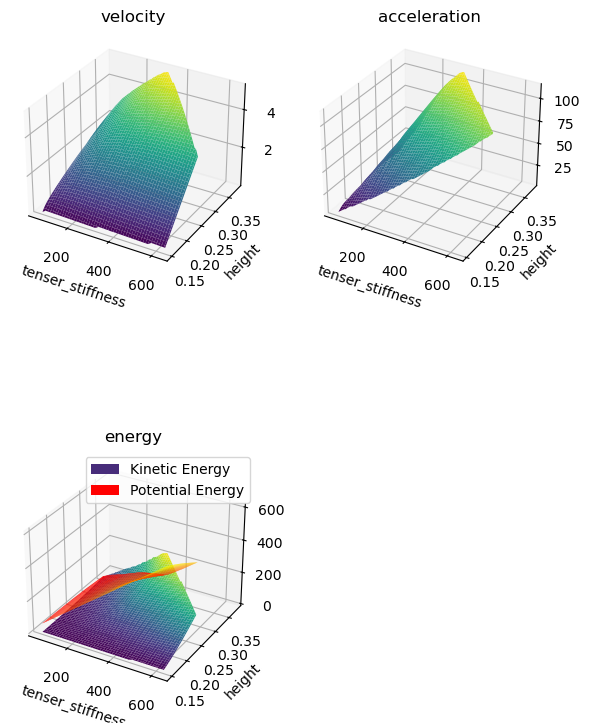

In [8]:
# 剔除None的数据
# 速度
y = [item for sublist in allData.all_cm_height_datas for item in sublist]
z = [item for sublist in allData.all_cm_velocity_datas for item in sublist]
x = [item for sublist in allData.all_tenser_stiffness_datas for item in sublist]

indices_to_exclude = []
for index, item in enumerate(z):
    if item is None:
        indices_to_exclude.append(index)
x = np.delete(x, indices_to_exclude)
y = np.delete(y, indices_to_exclude)
z = np.delete(z, indices_to_exclude)

X, Y = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
Z = griddata((x, y), z, (X, Y), method='cubic')
fig = plt.figure(figsize=(7, 10))
ax1 = fig.add_subplot(221, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis')
ax1.set_xlabel('tenser_stiffness')
ax1.set_ylabel('height')
ax1.set_title('velocity')
# 加速度
y = [item for sublist in allData.all_cm_height_datas for item in sublist]
x = [item for sublist in allData.all_tenser_stiffness_datas for item in sublist]
z = [item for sublist in allData.all_cm_acceleration_datas for item in sublist]

indices_to_exclude = []
for index, item in enumerate(z):
    if item is None:
        indices_to_exclude.append(index)
x = np.delete(x, indices_to_exclude)
y = np.delete(y, indices_to_exclude)
z = np.delete(z, indices_to_exclude)

X, Y = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
Z = griddata((x, y), z, (X, Y), method='cubic')
ax1 = fig.add_subplot(222, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis')
ax1.set_xlabel('tenser_stiffness')
ax1.set_ylabel('height')
ax1.set_title('acceleration')
# ax1.view_init(elev=30, azim=45)

# 动能
y = [item for sublist in allData.all_cm_height_datas for item in sublist]
x = [item for sublist in allData.all_tenser_stiffness_datas for item in sublist]
z = [item for sublist in allData.all_kinetic_energy_datas for item in sublist]

indices_to_exclude = []
for index, item in enumerate(z):
    if item is None:
        indices_to_exclude.append(index)
x = np.delete(x, indices_to_exclude)
y = np.delete(y, indices_to_exclude)
z = np.delete(z, indices_to_exclude)

X_kinetic, Y_kinetic = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
Z_kinetic = griddata((x, y), z, (X, Y), method='cubic')

# 势能
y = [item for sublist in allData.all_cm_height_datas for item in sublist]
x = [item for sublist in allData.all_tenser_stiffness_datas for item in sublist]
z = [item for sublist in allData.all_potential_energy_datas for item in sublist]

indices_to_exclude = []
for index, item in enumerate(z):
    if item is None:
        indices_to_exclude.append(index)
x = np.delete(x, indices_to_exclude)
y = np.delete(y, indices_to_exclude)
z = np.delete(z, indices_to_exclude)

X_potential, Y_potential = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
Z_potential = griddata((x, y), z, (X, Y), method='cubic')
ax1 = fig.add_subplot(223, projection='3d')
ax1.plot_surface(X_kinetic, Y_kinetic, Z_kinetic, cmap='viridis', label='Kinetic Energy')
ax1.plot_surface(X_potential, Y_potential, Z_potential, cmap='autumn', label='Potential Energy')
plt.legend()
ax1.set_xlabel('tenser_stiffness')
ax1.set_ylabel('height')
ax1.set_title('energy')
plt.tight_layout()
plt.show()

## 改变弹簧原长实验
弹簧刚度为100，原长从0.1提升到1


In [9]:
num_of_test = 20 # 试验次数

def task(queue, i):
    xml_path = "./xml/hopper1/scene.xml"
    sim = Hopper1(xml_path)
    sim.model.tendon_lengthspring[0] = [0.1 + i*0.05, 0.1 + i*0.05]
    print(f'第{i+1}次实验，弹簧原长为{sim.model.tendon_lengthspring[0, 0]}。\n')
    sim.is_render = False
    sim.is_plot_data = False
    sim.is_save_data = False
    sim.is_save_image = False
    sim.simend = 2.0
    sim.Hz = 30
    sim.reset()
    sim.simulate()
    for index, data in enumerate(sim.hopperdata.jump_height_datas):
        # 只采集离地前的数据，获取离地前的数据的在列表中的位置i
        if abs(data) >= 0.01:
            break
    queue.put((sim.hopperdata.time_datas[:index], sim.hopperdata.kinetic_energy_datas[:index],
               sim.hopperdata.potential_energy_datas[:index],sim.hopperdata.total_energy_datas[:index],
               sim.hopperdata.cm_pos_z_datas[:index], sim.hopperdata.cm_vel_z_datas[:index],
               sim.hopperdata.cm_acc_z_datas[:index], [sim.model.tendon_lengthspring[0, 0]]*index))

def main(allData):
    queue = multiprocessing.Queue()
    processes = []
    for i in range(num_of_test):
        p = multiprocessing.Process(target=task, args=(queue, i))
        processes.append(p)
        p.start()

    allData.all_time_datas, allData.all_kinetic_energy_datas, \
    allData.all_potential_energy_datas, allData.all_total_energy_datas, \
    allData.all_cm_height_datas, allData.all_cm_velocity_datas, \
    allData.all_cm_acceleration_datas, allData.all_tenser_length_datas = \
    zip(*[queue.get() for _ in range(num_of_test)])
    
    for p in processes:
        p.join()
        
if __name__ == "__main__":
    allData = AllData()
    main(allData)

第1次实验，弹簧原长为0.1。

第2次实验，弹簧原长为0.15000000000000002。

第3次实验，弹簧原长为0.2。

第4次实验，弹簧原长为0.25。

第5次实验，弹簧原长为0.30000000000000004。

第6次实验，弹簧原长为0.35。

第7次实验，弹簧原长为0.4。
第8次实验，弹簧原长为0.45000000000000007。


第9次实验，弹簧原长为0.5。

第10次实验，弹簧原长为0.55。

第11次实验，弹簧原长为0.6。

第12次实验，弹簧原长为0.65。
第13次实验，弹簧原长为0.7000000000000001。


第15次实验，弹簧原长为0.8。


第14次实验，弹簧原长为0.75。
第16次实验，弹簧原长为0.85。

第17次实验，弹簧原长为0.9。

第18次实验，弹簧原长为0.9500000000000001。

第19次实验，弹簧原长为1.0。

第20次实验，弹簧原长为1.05。



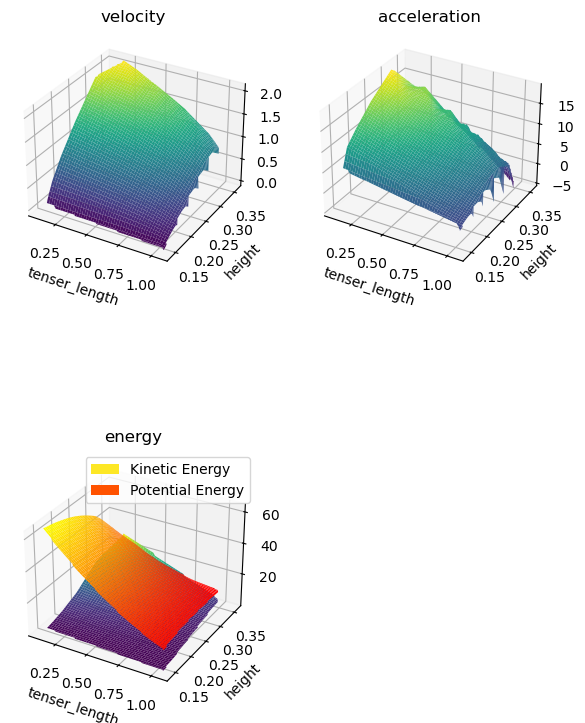

In [13]:
# 剔除None的数据
# 速度
y = [item for sublist in allData.all_cm_height_datas for item in sublist]
z = [item for sublist in allData.all_cm_velocity_datas for item in sublist]
x = [item for sublist in allData.all_tenser_length_datas for item in sublist]

indices_to_exclude = []
for index, item in enumerate(z):
    if item is None:
        indices_to_exclude.append(index)
x = np.delete(x, indices_to_exclude)
y = np.delete(y, indices_to_exclude)
z = np.delete(z, indices_to_exclude)

X, Y = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
Z = griddata((x, y), z, (X, Y), method='linear')
fig = plt.figure(figsize=(7, 10))
ax1 = fig.add_subplot(221, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis')
ax1.set_xlabel('tenser_length')
ax1.set_ylabel('height')
ax1.set_title('velocity')
# 加速度
y = [item for sublist in allData.all_cm_height_datas for item in sublist]
x = [item for sublist in allData.all_tenser_length_datas for item in sublist]
z = [item for sublist in allData.all_cm_acceleration_datas for item in sublist]

indices_to_exclude = []
for index, item in enumerate(z):
    if item is None:
        indices_to_exclude.append(index)
x = np.delete(x, indices_to_exclude)
y = np.delete(y, indices_to_exclude)
z = np.delete(z, indices_to_exclude)

X, Y = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
Z = griddata((x, y), z, (X, Y), method='linear')
ax1 = fig.add_subplot(222, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis')
ax1.set_xlabel('tenser_length')
ax1.set_ylabel('height')
ax1.set_title('acceleration')
# ax1.view_init(elev=30, azim=45)

# 动能
y = [item for sublist in allData.all_cm_height_datas for item in sublist]
x = [item for sublist in allData.all_tenser_length_datas for item in sublist]
z = [item for sublist in allData.all_kinetic_energy_datas for item in sublist]

indices_to_exclude = []
for index, item in enumerate(z):
    if item is None:
        indices_to_exclude.append(index)
x = np.delete(x, indices_to_exclude)
y = np.delete(y, indices_to_exclude)
z = np.delete(z, indices_to_exclude)

X_kinetic, Y_kinetic = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
Z_kinetic = griddata((x, y), z, (X, Y), method='linear')

# 势能
y = [item for sublist in allData.all_cm_height_datas for item in sublist]
x = [item for sublist in allData.all_tenser_length_datas for item in sublist]
z = [item for sublist in allData.all_potential_energy_datas for item in sublist]

indices_to_exclude = []
for index, item in enumerate(z):
    if item is None:
        indices_to_exclude.append(index)
x = np.delete(x, indices_to_exclude)
y = np.delete(y, indices_to_exclude)
z = np.delete(z, indices_to_exclude)

X_potential, Y_potential = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
Z_potential = griddata((x, y), z, (X, Y), method='cubic')
ax1 = fig.add_subplot(223, projection='3d')
ax1.plot_surface(X_kinetic, Y_kinetic, Z_kinetic, cmap='viridis', label='Kinetic Energy')
ax1.plot_surface(X_potential, Y_potential, Z_potential, cmap='autumn', label='Potential Energy')
plt.legend()
ax1.set_xlabel('tenser_length')
ax1.set_ylabel('height')
ax1.set_title('energy')
plt.tight_layout()
plt.show()

## 改变弹簧的布置，增加多一条竖直布置的弹簧
两个弹簧刚度不变，都为50，第一个弹簧原长不变，第二个弹簧原长从0.2变化到1


In [7]:
num_of_test = 20 # 试验次数

def task(queue, i):
    xml_path = "./xml/hopper1/hopper4.xml"
    sim = Hopper1(xml_path)
    sim.model.tendon_lengthspring[1] = [0.1 + i*0.05, 0.1 + i*0.05]
    print(f'第{i+1}次实验，弹簧原长为{sim.model.tendon_lengthspring[1, 0]}。\n')
    sim.is_render = False
    sim.is_plot_data = False
    sim.is_save_data = False
    sim.is_save_image = False
    sim.simend = 2.0
    sim.Hz = 30
    sim.reset()
    sim.simulate()
    for index, data in enumerate(sim.hopperdata.jump_height_datas):
        # 只采集离地前的数据，获取离地前的数据的在列表中的位置i
        if abs(data) >= 0.01:
            break
    queue.put((sim.hopperdata.time_datas[:index], sim.hopperdata.kinetic_energy_datas[:index],
               sim.hopperdata.potential_energy_datas[:index],sim.hopperdata.total_energy_datas[:index],
               sim.hopperdata.cm_pos_z_datas[:index], sim.hopperdata.cm_vel_z_datas[:index],
               sim.hopperdata.cm_acc_z_datas[:index], [sim.model.tendon_lengthspring[1, 0]]*index))

def main(allData):
    queue = multiprocessing.Queue()
    processes = []
    for i in range(num_of_test):
        p = multiprocessing.Process(target=task, args=(queue, i))
        processes.append(p)
        p.start()

    allData.all_time_datas, allData.all_kinetic_energy_datas, \
    allData.all_potential_energy_datas, allData.all_total_energy_datas, \
    allData.all_cm_height_datas, allData.all_cm_velocity_datas, \
    allData.all_cm_acceleration_datas, allData.all_tenser_length_datas = \
    zip(*[queue.get() for _ in range(num_of_test)])
    
    for p in processes:
        p.join()
        
if __name__ == "__main__":
    allData = AllData()
    main(allData)

第1次实验，弹簧原长为0.1。

第2次实验，弹簧原长为0.15000000000000002。

第3次实验，弹簧原长为0.2。
第4次实验，弹簧原长为0.25。


第5次实验，弹簧原长为0.30000000000000004。
第6次实验，弹簧原长为0.35。


第7次实验，弹簧原长为0.4。

第8次实验，弹簧原长为0.45000000000000007。
第9次实验，弹簧原长为0.5。


第10次实验，弹簧原长为0.55。

第11次实验，弹簧原长为0.6。

第12次实验，弹簧原长为0.65。

第13次实验，弹簧原长为0.7000000000000001。

第14次实验，弹簧原长为0.75。

第15次实验，弹簧原长为0.8。

第16次实验，弹簧原长为0.85。

第17次实验，弹簧原长为0.9。

第18次实验，弹簧原长为0.9500000000000001。

第19次实验，弹簧原长为1.0。

第20次实验，弹簧原长为1.05。



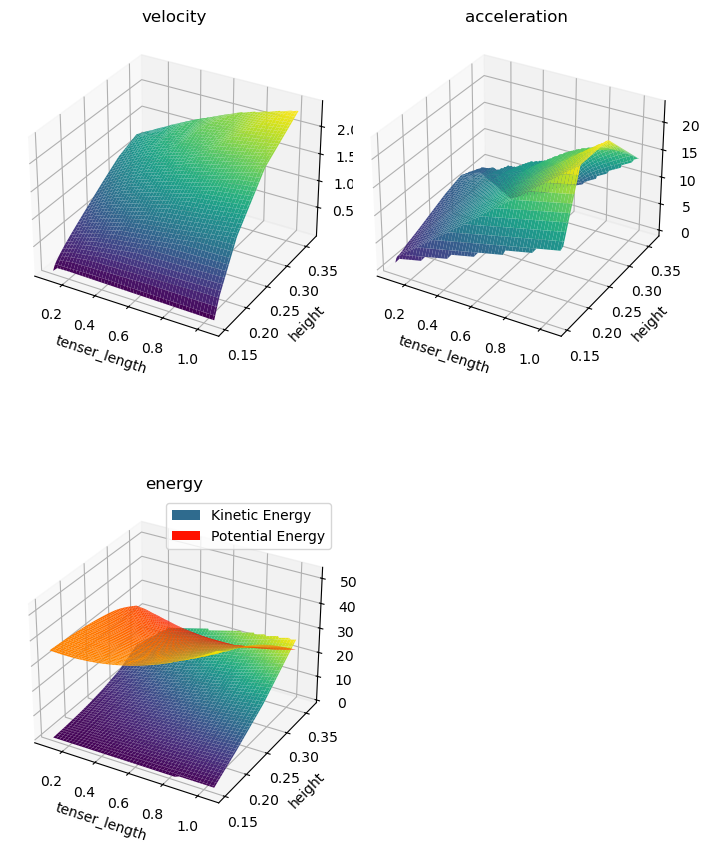

In [8]:
# 剔除None的数据
# 速度
y = [item for sublist in allData.all_cm_height_datas for item in sublist]
z = [item for sublist in allData.all_cm_velocity_datas for item in sublist]
x = [item for sublist in allData.all_tenser_length_datas for item in sublist]

indices_to_exclude = []
for index, item in enumerate(z):
    if item is None:
        indices_to_exclude.append(index)
x = np.delete(x, indices_to_exclude)
y = np.delete(y, indices_to_exclude)
z = np.delete(z, indices_to_exclude)

X, Y = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
Z = griddata((x, y), z, (X, Y), method='linear')
fig = plt.figure(figsize=(7, 10))
ax1 = fig.add_subplot(221, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis')
ax1.set_xlabel('tenser_length')
ax1.set_ylabel('height')
ax1.set_title('velocity')
# 加速度
y = [item for sublist in allData.all_cm_height_datas for item in sublist]
x = [item for sublist in allData.all_tenser_length_datas for item in sublist]
z = [item for sublist in allData.all_cm_acceleration_datas for item in sublist]

indices_to_exclude = []
for index, item in enumerate(z):
    if item is None:
        indices_to_exclude.append(index)
x = np.delete(x, indices_to_exclude)
y = np.delete(y, indices_to_exclude)
z = np.delete(z, indices_to_exclude)

X, Y = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
Z = griddata((x, y), z, (X, Y), method='linear')
ax1 = fig.add_subplot(222, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis')
ax1.set_xlabel('tenser_length')
ax1.set_ylabel('height')
ax1.set_title('acceleration')
# ax1.view_init(elev=30, azim=45)

# 动能
y = [item for sublist in allData.all_cm_height_datas for item in sublist]
x = [item for sublist in allData.all_tenser_length_datas for item in sublist]
z = [item for sublist in allData.all_kinetic_energy_datas for item in sublist]

indices_to_exclude = []
for index, item in enumerate(z):
    if item is None:
        indices_to_exclude.append(index)
x = np.delete(x, indices_to_exclude)
y = np.delete(y, indices_to_exclude)
z = np.delete(z, indices_to_exclude)

X_kinetic, Y_kinetic = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
Z_kinetic = griddata((x, y), z, (X, Y), method='linear')

# 势能
y = [item for sublist in allData.all_cm_height_datas for item in sublist]
x = [item for sublist in allData.all_tenser_length_datas for item in sublist]
z = [item for sublist in allData.all_potential_energy_datas for item in sublist]

indices_to_exclude = []
for index, item in enumerate(z):
    if item is None:
        indices_to_exclude.append(index)
x = np.delete(x, indices_to_exclude)
y = np.delete(y, indices_to_exclude)
z = np.delete(z, indices_to_exclude)

X_potential, Y_potential = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))
Z_potential = griddata((x, y), z, (X, Y), method='cubic')
ax1 = fig.add_subplot(223, projection='3d')
ax1.plot_surface(X_kinetic, Y_kinetic, Z_kinetic, cmap='viridis', label='Kinetic Energy')
ax1.plot_surface(X_potential, Y_potential, Z_potential, cmap='autumn', label='Potential Energy')
plt.legend()
ax1.set_xlabel('tenser_length')
ax1.set_ylabel('height')
ax1.set_title('energy')
plt.tight_layout()
plt.show()

0
